### pandas - read html
- [台灣銀行 - 歷史匯率查詢](https://rate.bot.com.tw/xrt/history)

In [1]:
import pandas as pd

df_list = pd.read_html('https://rate.bot.com.tw/xrt/quote/l6m/USD?Lang=en-US')
df = df_list[0].dropna(axis=1)
df.columns = ['Quoted Date', 'Currency',
              'Cash Rate - Buying', 'Cash Rate - Selling',
              'Spot Rate - Buying', 'Spot Rate - Selling']
df.head()

,Quoted Date,Currency,Cash Rate - Buying,Cash Rate - Selling,Spot Rate - Buying,Spot Rate - Selling
0,2019/08/07,American Dollar (USD),31.065,31.735,31.415,31.515
1,2019/08/06,American Dollar (USD),31.090,31.760,31.440,31.540
2,2019/08/05,American Dollar (USD),31.215,31.885,31.565,31.665
3,2019/08/02,American Dollar (USD),30.975,31.645,31.325,31.425
4,2019/08/01,American Dollar (USD),30.770,31.440,31.120,31.220


### crawler - get html

In [2]:
import requests
from bs4 import BeautifulSoup

url = 'https://rate.bot.com.tw/xrt/quote/l6m/USD?Lang=en-US'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# response.text

### crawler - download csv
- [台灣銀行 - 歷史匯率查詢 - 下載 Excel (CSV) 檔](https://rate.bot.com.tw/xrt/flcsv/0/l6m/USD)

In [3]:
link = soup.select_one('a#GetExcelFile').get('href')
url = 'https://rate.bot.com.tw' + link + '?Lang=en-US'
html = requests.get(url, allow_redirects=True)

with open('./exchange_rate.csv', 'wb') as file:
    file.write(html.content)

file = open('./exchange_rate.csv', 'rb')
csv = pd.read_csv(file, index_col=False)
csv.head()

,Data Date,Currency,Rate,Cash,Spot,Forward-10Days,Forward-30Days,Forward-60Days,Forward-90Days,Forward-120Days,...,Rate.1,Cash.1,Spot.1,Forward-10Days.1,Forward-30Days.1,Forward-60Days.1,Forward-90Days.1,Forward-120Days.1,Forward-150Days.1,Forward-180Days.1
0,20190807,USD,Buying,31.065,31.415,31.396,31.357,31.307,31.252,31.206,...,Selling,31.735,31.515,31.499,31.468,31.418,31.362,31.329,31.283,31.241
1,20190806,USD,Buying,31.090,31.440,31.420,31.380,31.332,31.281,31.229,...,Selling,31.760,31.540,31.525,31.494,31.445,31.395,31.359,31.320,31.273
2,20190805,USD,Buying,31.215,31.565,31.544,31.502,31.453,31.404,31.350,...,Selling,31.885,31.665,31.648,31.615,31.568,31.516,31.474,31.433,31.388
3,20190802,USD,Buying,30.975,31.325,31.305,31.266,31.213,31.164,31.112,...,Selling,31.645,31.425,31.409,31.377,31.325,31.275,31.230,31.182,31.143
4,20190801,USD,Buying,30.770,31.120,31.100,31.060,31.005,30.953,30.905,...,Selling,31.440,31.220,31.204,31.171,31.118,31.069,31.022,30.971,30.929


### parse html table

In [4]:
table = soup.select_one('table')

# table

#### table columns name

In [5]:
header = table.find('thead')
rows = header.find_all('tr')

data = list()
for row in rows:
    cols = row.find_all('th')
    cols = [item.text.strip() for item in cols]
    data.append(cols)
header = data

header[0][4], header[0][6] = header[0][3], header[0][5]
for i in range(4):
    title = header[0][i + 3]
    subtitle = header[1][i]
    header[0][i + 3] = title + ' - ' + subtitle
header = header[0][1:]

header

['Quoted Date',
 'Currency',
 'Cash Rate - Buying',
 'Cash Rate - Selling',
 'Spot Rate - Buying',
 'Spot Rate - Selling']

#### table rows data

In [6]:
from datetime import datetime

body = table.find('tbody')
rows = body.find_all('tr')

data = list()
for row in rows:
    cols = row.find_all('td')
    for i in range(6):
        if i == 0:
            cols[i] = datetime.strptime(cols[i].text, '%Y/%m/%d')
        elif i == 1:
            cols[i] = cols[i].text.strip()
        else:
            cols[i] = float(cols[i].text)
    data.append(cols)
data.reverse()
body = data

# body

### draw table

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
df = pd.DataFrame(body, columns=header)

cash_rate = df.loc[:, ['Cash Rate - Buying', 'Cash Rate - Selling']]
spot_rate = df.loc[:, ['Spot Rate - Buying', 'Spot Rate - Selling']]

In [9]:
df.head()

,Quoted Date,Currency,Cash Rate - Buying,Cash Rate - Selling,Spot Rate - Buying,Spot Rate - Selling
0,2019-02-11,American Dollar (USD),30.38,31.07,30.75,30.85
1,2019-02-12,American Dollar (USD),30.41,31.10,30.78,30.88
2,2019-02-13,American Dollar (USD),30.41,31.10,30.78,30.88
3,2019-02-14,American Dollar (USD),30.41,31.10,30.78,30.88
4,2019-02-15,American Dollar (USD),30.43,31.12,30.80,30.90


In [10]:
df.describe()

,Cash Rate - Buying,Cash Rate - Selling,Spot Rate - Buying,Spot Rate - Selling
count,123.000000,123.00000,123.00000,123.00000
mean,30.641667,31.32435,31.00435,31.10435
std,0.253634,0.24919,0.24919,0.24919
min,30.350000,31.04000,30.72000,30.82000
25%,30.420000,31.11000,30.79000,30.89000
50%,30.580000,31.25000,30.93000,31.03000
75%,30.745000,31.42500,31.10500,31.20500
max,31.215000,31.88500,31.56500,31.66500


### draw chart

In [11]:
# from matplotlib.font_manager import FontProperties

# font = FontProperties(fname='./NotoSansTC-Regular.otf', size=14)

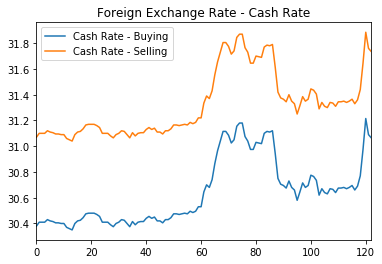

In [12]:
# cash_rate = cash_rate.astype(float)
chart = cash_rate.plot(title='Foreign Exchange Rate - Cash Rate')
# chart.set_xticklabels(cash_rate.columns, fontproperties=font)
# chart.invert_xaxis()

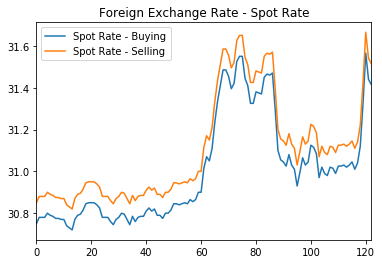

In [13]:
spot_rate = spot_rate.plot(title='Foreign Exchange Rate - Spot Rate')

### multi foreign rate

In [14]:
def get_data(url):
    html = requests.get(url)

    soup = BeautifulSoup(html.text, 'html.parser')
    table = soup.select_one('table')

    header = table.find('thead')
    rows = header.find_all('tr')
    # ------------------------------
    data = list()
    for row in rows:
        cols = row.find_all('th')
        cols = [item.text.strip() for item in cols]
        data.append(cols)
    header = data

    header[0][4], header[0][6] = header[0][3], header[0][5]
    for i in range(4):
        title = header[0][i + 3]
        subtitle = header[1][i]
        header[0][i + 3] = title + ' - ' + subtitle
    header = header[0][1:]
    # ------------------------------
    body = table.find('tbody')
    rows = body.find_all('tr')

    data = list()
    for row in rows:
        cols = row.find_all('td')
        for i in range(6):
            if i == 0:
                cols[i] = datetime.strptime(cols[i].text, '%Y/%m/%d')
            elif i == 1:
                cols[i] = cols[i].text.strip()
            else:
                cols[i] = float(cols[i].text)
        data.append(cols)
    data.reverse()
    body = data

    return header, body

In [15]:
usd_url = 'https://rate.bot.com.tw/xrt/quote/l6m/USD?Lang=en-US'
usd_header, usd_body = get_data(usd_url)
jpy_url = 'https://rate.bot.com.tw/xrt/quote/l6m/JPY?Lang=en-US'
jpy_header, jpy_body = get_data(jpy_url)
cny_url = 'https://rate.bot.com.tw/xrt/quote/l6m/CNY?Lang=en-US'
cny_header, cny_body = get_data(cny_url)

In [16]:
def make_df(header, body):
    df = pd.DataFrame(body, columns=header)
    cash_rate = df.loc[:, ['Cash Rate - Buying', 'Cash Rate - Selling']]
    spot_rate = df.loc[:, ['Spot Rate - Buying', 'Spot Rate - Selling']]
    return df, cash_rate, spot_rate

In [17]:
usd_df, usd_cash_rate, usd_spot_rate = make_df(usd_header, usd_body)

In [18]:
usd_df.head()

,Quoted Date,Currency,Cash Rate - Buying,Cash Rate - Selling,Spot Rate - Buying,Spot Rate - Selling
0,2019-02-11,American Dollar (USD),30.38,31.07,30.75,30.85
1,2019-02-12,American Dollar (USD),30.41,31.10,30.78,30.88
2,2019-02-13,American Dollar (USD),30.41,31.10,30.78,30.88
3,2019-02-14,American Dollar (USD),30.41,31.10,30.78,30.88
4,2019-02-15,American Dollar (USD),30.43,31.12,30.80,30.90


In [19]:
usd_df.describe()

,Cash Rate - Buying,Cash Rate - Selling,Spot Rate - Buying,Spot Rate - Selling
count,123.000000,123.00000,123.00000,123.00000
mean,30.641667,31.32435,31.00435,31.10435
std,0.253634,0.24919,0.24919,0.24919
min,30.350000,31.04000,30.72000,30.82000
25%,30.420000,31.11000,30.79000,30.89000
50%,30.580000,31.25000,30.93000,31.03000
75%,30.745000,31.42500,31.10500,31.20500
max,31.215000,31.88500,31.56500,31.66500


In [20]:
jpy_df, jpy_cash_rate, jpy_spot_rate = make_df(jpy_header, jpy_body)

In [21]:
jpy_df.head()

,Quoted Date,Currency,Cash Rate - Buying,Cash Rate - Selling,Spot Rate - Buying,Spot Rate - Selling
0,2019-02-11,Japanese Yen (JPY),0.2708,0.2836,0.2781,0.2821
1,2019-02-12,Japanese Yen (JPY),0.2694,0.2822,0.2767,0.2807
2,2019-02-13,Japanese Yen (JPY),0.2693,0.2821,0.2766,0.2806
3,2019-02-14,Japanese Yen (JPY),0.2683,0.2811,0.2756,0.2796
4,2019-02-15,Japanese Yen (JPY),0.2704,0.2832,0.2777,0.2817


In [22]:
jpy_df.describe()

,Cash Rate - Buying,Cash Rate - Selling,Spot Rate - Buying,Spot Rate - Selling
count,123.000000,123.000000,123.000000,123.000000
mean,0.273776,0.286576,0.281076,0.285076
std,0.005820,0.005820,0.005820,0.005820
min,0.266100,0.278900,0.273400,0.277400
25%,0.268200,0.281000,0.275500,0.279500
50%,0.274100,0.286900,0.281400,0.285400
75%,0.278500,0.291300,0.285800,0.289800
max,0.289100,0.301900,0.296400,0.300400


In [23]:
cny_df, cny_cash_rate, cny_spot_rate = make_df(cny_header, cny_body)

In [24]:
cny_df.head()

,Quoted Date,Currency,Cash Rate - Buying,Cash Rate - Selling,Spot Rate - Buying,Spot Rate - Selling
0,2019-02-11,China Yen (CNY),4.440,4.602,4.512,4.562
1,2019-02-12,China Yen (CNY),4.445,4.607,4.517,4.567
2,2019-02-13,China Yen (CNY),4.457,4.619,4.529,4.579
3,2019-02-14,China Yen (CNY),4.454,4.616,4.526,4.576
4,2019-02-15,China Yen (CNY),4.446,4.608,4.518,4.568


In [25]:
cny_df.describe()

,Cash Rate - Buying,Cash Rate - Selling,Spot Rate - Buying,Spot Rate - Selling
count,123.000000,123.000000,123.000000,123.000000
mean,4.454772,4.616772,4.526772,4.576772
std,0.036713,0.036713,0.036713,0.036713
min,4.352000,4.514000,4.424000,4.474000
25%,4.422000,4.584000,4.494000,4.544000
50%,4.449000,4.611000,4.521000,4.571000
75%,4.491000,4.653000,4.563000,4.613000
max,4.515000,4.677000,4.587000,4.637000


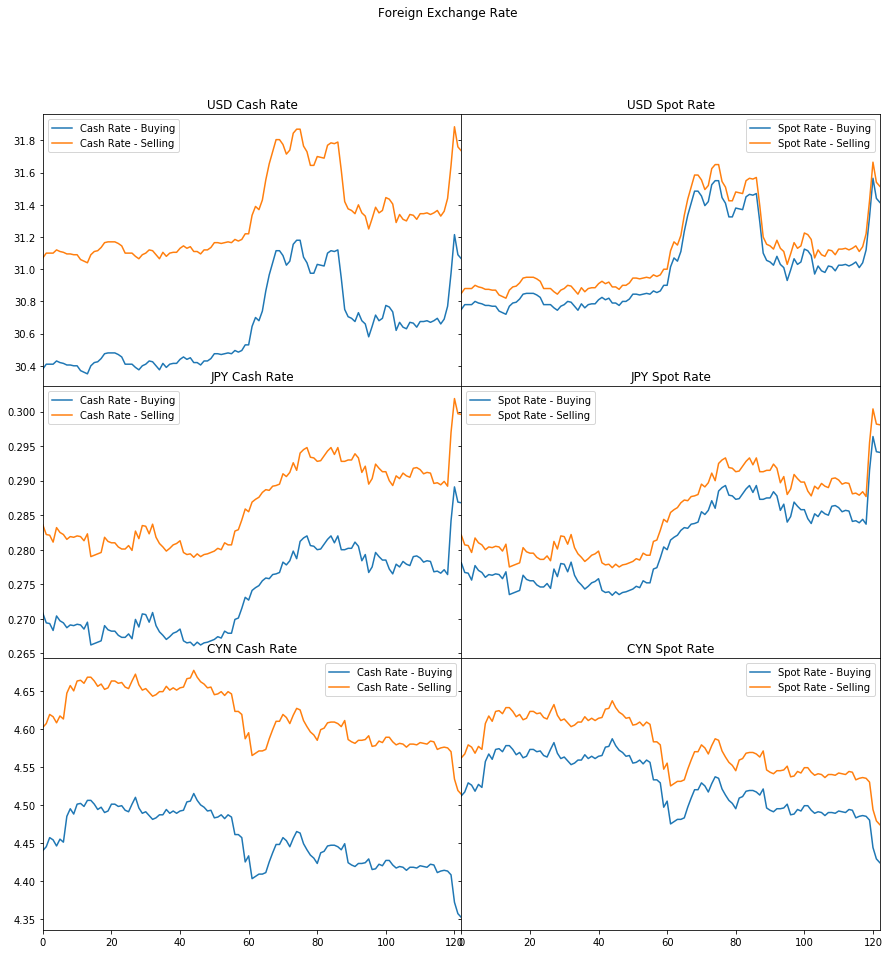

In [26]:
figure, axes = plt.subplots(figsize=(15, 15),
                            nrows=3, ncols=2,
                            sharex='col', sharey='row',
                            gridspec_kw={'hspace': 0, 'wspace': 0})
figure.suptitle('Foreign Exchange Rate')

usd_cash_rate.plot(ax=axes[0, 0], title='USD Cash Rate')
usd_spot_rate.plot(ax=axes[0, 1], title='USD Spot Rate')
jpy_cash_rate.plot(ax=axes[1, 0], title='JPY Cash Rate')
jpy_spot_rate.plot(ax=axes[1, 1], title='JPY Spot Rate')
cny_cash_rate.plot(ax=axes[2, 0], title='CYN Cash Rate')
cny_spot_rate.plot(ax=axes[2, 1], title='CYN Spot Rate')

In [27]:
foreign_rate = pd.concat([usd_df, jpy_df, cny_df], join='outer')
foreign_rate.groupby(['Currency']).describe()

Cash Rate - Buying                                \
                                   count       mean       std      min   
Currency                                                                 
American Dollar (USD)              123.0  30.641667  0.253634  30.3500   
China Yen (CNY)                    123.0   4.454772  0.036713   4.3520   
Japanese Yen (JPY)                 123.0   0.273776  0.005820   0.2661   

                                                          Cash Rate - Selling  \
                           25%      50%      75%      max               count   
Currency                                                                        
American Dollar (USD)  30.4200  30.5800  30.7450  31.2150               123.0   
China Yen (CNY)         4.4220   4.4490   4.4910   4.5150               123.0   
Japanese Yen (JPY)      0.2682   0.2741   0.2785   0.2891               123.0   

                                  ... Spot Rate - Buying           \
                            mean  ...                75%      max   
Currency                          ...                               
American Dollar (USD)  31.324350  ...            31.1050  31.5650   
China Yen (CNY)         4.616772  ...             4.5630   4.5870   
Japanese Yen (JPY)      0.286576  ...             0.2858   0.2964   

                      Spot Rate - Selling                                \
                                    count       mean       std      min   
Currency                                                                  
American Dollar (USD)               123.0  31.104350  0.249190  30.8200   
China Yen (CNY)                     123.0   4.576772  0.036713   4.4740   
Japanese Yen (JPY)                  123.0   0.285076  0.005820   0.2774   

                                                           
                           25%      50%      75%      max  
Currency                                                   
American Dollar (USD)  30.8900  31.0300  31.2050  31.6650  
China Yen (CNY)         4.5440   4.5710   4.6130   4.6370  
Japanese Yen (JPY)      0.2795   0.2854   0.2898   0.3004  

[3 rows x 32 columns]

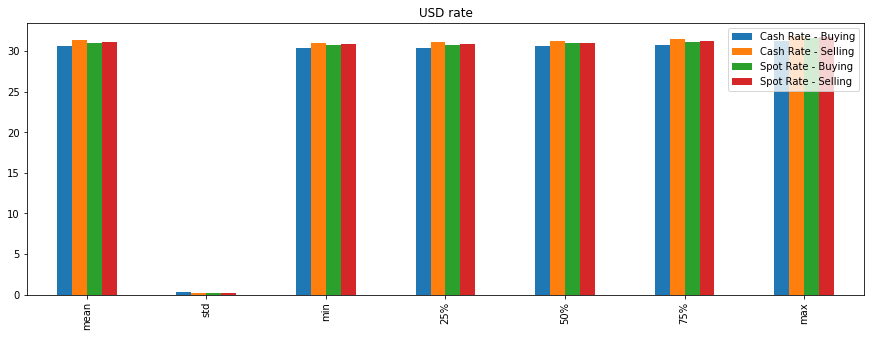

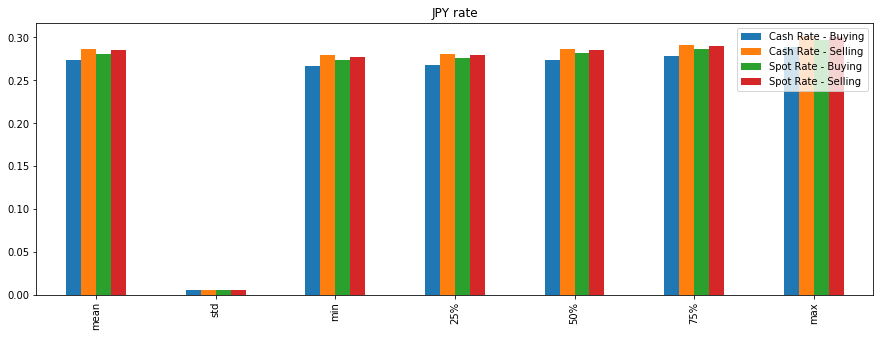

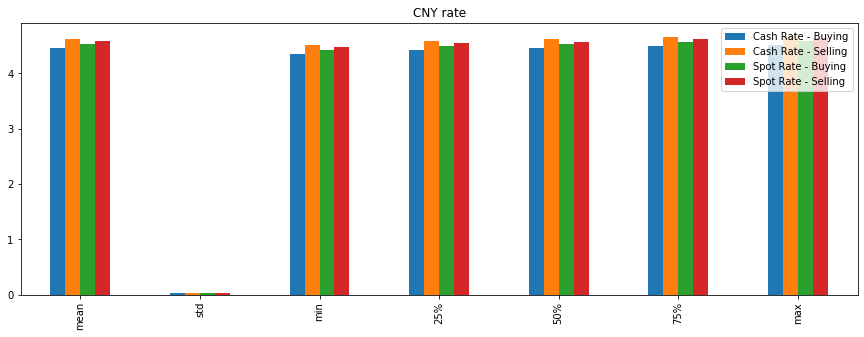

In [28]:
usd_df.describe().drop('count').plot(title='USD rate', kind='bar', figsize=(15, 5))
jpy_df.describe().drop('count').plot(title='JPY rate', kind='bar', figsize=(15, 5))
cny_df.describe().drop('count').plot(title='CNY rate', kind='bar', figsize=(15, 5))

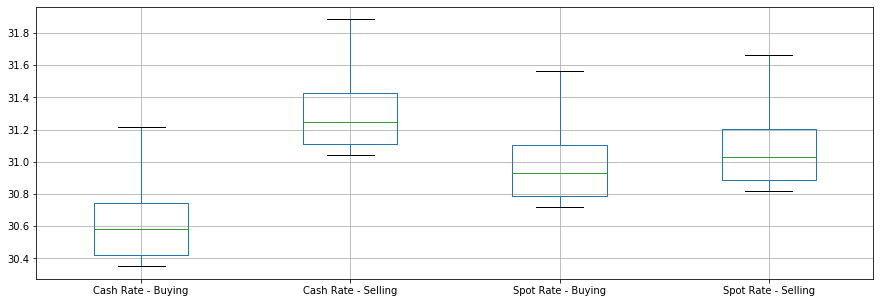

In [29]:
usd_df.boxplot(figsize=(15, 5))

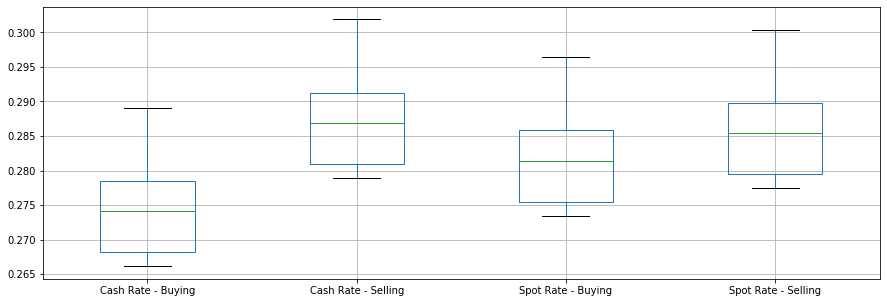

In [30]:
jpy_df.boxplot(figsize=(15, 5))

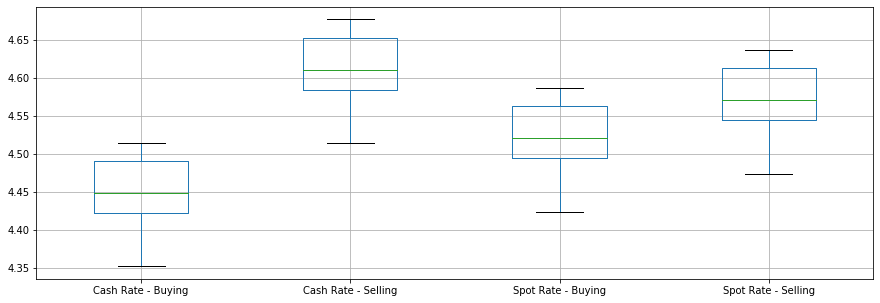

In [31]:
cny_df.boxplot(figsize=(15, 5))